# Other visualizations for the presentation

In [1]:
# BASIC IMPORTS BEFORE WE BEGIN
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import csv
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
import numpy as np
import random
import scipy.stats as ss

In [2]:
authordata = pd.read_csv('authordata.csv', index_col = 'author')
onlyboth = pd.read_csv('pairedwithprestige.csv', index_col = 'author')

In [3]:
crudedata = authordata
crudedata['binaryreview'] = 0
crudedata['centereddate'] = 0
crudedata['binarysales'] = 0
meandate = np.mean(crudedata.midcareer)
ctr = 0
for i in crudedata.index:
    crudedata.loc[i, 'centereddate'] = crudedata.loc[i, 'midcareer'] - meandate
    if crudedata.loc[i, 'reviews'] > 0:
        ctr += 1
        crudedata.loc[i, 'binaryreview'] = 1
    if crudedata.loc[i, 'salesevidence'] > 0:
        crudedata.loc[i, 'binarysales'] = 1
print(ctr)

from patsy import dmatrices
y, X = dmatrices('binarysales ~ binaryreview * centereddate + is_us', data=crudedata, return_type='dataframe')

crudelm = smf.Logit(y, X).fit()
crudelm.summary()

413
Optimization terminated successfully.
         Current function value: 0.530986
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            binarysales   No. Observations:                 1058
Model:                          Logit   Df Residuals:                     1053
Method:                           MLE   Df Model:                            4
Date:                Sat, 12 Aug 2017   Pseudo R-squ.:                 0.04956
Time:                        18:20:55   Log-Likelihood:                -561.78
converged:                       True   LL-Null:                       -591.07
                                        LLR p-value:                 5.756e-12
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.4459      0.131    -11.037      0.000      -1.703      -1.189
binaryreview                  0.3267      0.152      2.144      0.032       0.028       0.625
centereddate                  0.0243      0.004      6.575      0.000       0.017       0.032
binaryreview:centereddate    -0.0259      0.005     -4.726      0.000      -0.037      -0.015
is_us                         0.2699      0.149      1.809      0.070      -0.023       0.562
=============================================================================================
"""

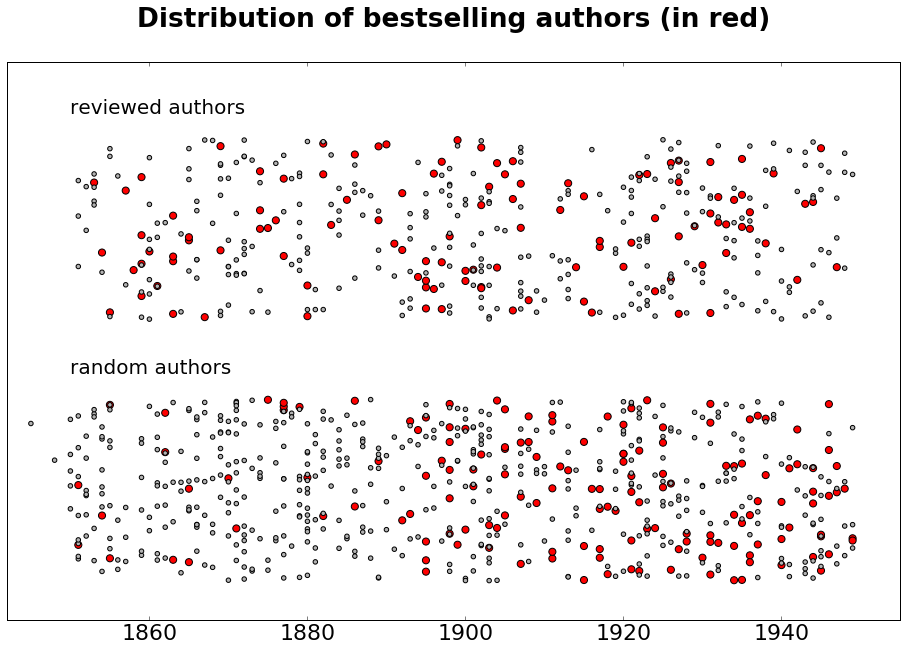

In [5]:
plotdata = crudedata.loc[ : , ['binaryreview', 'binarysales', 'midcareer']]
equiv = {0: '0.7', 1: 'r'}
plotdata['colors'] = plotdata.binarysales.map(equiv)
for i in plotdata.index:
    plotdata.loc[i, 'binaryreview'] = plotdata.loc[i, 'binaryreview'] + random.uniform(-0.35, 0.35)
import matplotlib

fig, ax = plt.subplots(figsize = (16,10))
# matplotlib.pylab.rcParams['figure.figsize'] = 16, 10
# plotdata.plot.scatter(x = 'midcareer', y = 'binaryreview', c = plotdata.colors, s = (plotdata.binarysales * 30) + 20)
plt.scatter(plotdata.midcareer, plotdata.binaryreview, c = plotdata.colors, s = (plotdata.binarysales * 30) + 20)
matplotlib.rcParams.update({'font.size': 22})
plt.xlim(1842, 1955)
plt.ylim(-0.5, 1.65)
ax.set_ylabel('')
ax.set_xlabel('')
ax.text(1850, 1.45, 'reviewed authors', fontsize=20)
ax.text(1850, 0.45, 'random authors', fontsize=20)
ax.set_title('Distribution of bestselling authors (in red)\n', fontweight = 'bold')
ax.set_yticklabels([])
ax.yaxis.set_ticks_position('none')
# fig.savefig('images/authorscatter.png', bbox_inches='tight')
plt.show()

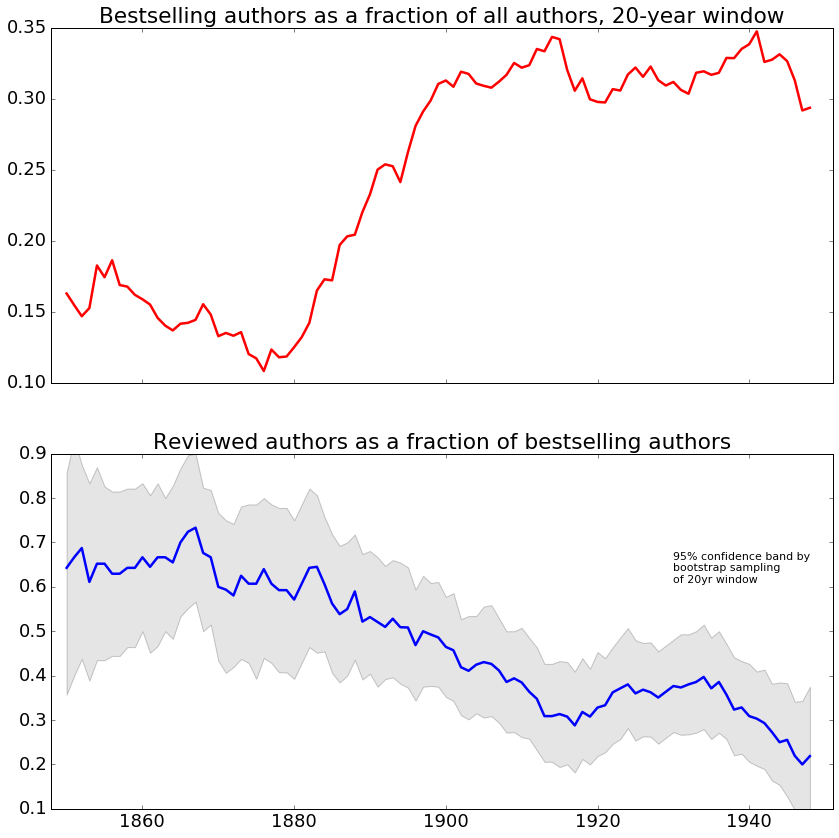

In [6]:
bestinall = []
revinallbest = []
raibmax = []
raibmin = []
for i in range(1850, 1949):
    floor = i - 10
    ceiling = i + 10
    timeslice = crudedata[(crudedata.midcareer >= floor) & (crudedata.midcareer < ceiling)]
    allauthors = len(timeslice)
    bestsellingauthors = np.sum(timeslice.binarysales)
    bestandreviewed = np.sum((timeslice.binarysales > 0.5) & (timeslice.binaryreview > 0))
    bestinall.append(bestsellingauthors / allauthors)
    revinallbest.append(bestandreviewed / bestsellingauthors)
    samplemeans = []
    thebestsellers = timeslice[timeslice.binarysales > 0.5]
    totallen = len(thebestsellers)
    for i in range(1000):
        thissample = np.random.choice(thebestsellers.binaryreview, replace = True, 
                         size = totallen)
        samplemeans.append(np.sum(thissample) / totallen)
    samplemeans = sorted(samplemeans)
    raibmin.append(samplemeans[25])
    raibmax.append(samplemeans[975])     

x = list(range(1850,1949))
# Two subplots, sharing the X axis
fig, axarr = plt.subplots(2, sharex = True, figsize = (14,14))
matplotlib.rcParams.update({'font.size': 18})
axarr[0].plot(x, bestinall, c = 'red', linewidth = 2.5)
axarr[0].set_title('Bestselling authors as a fraction of all authors, 20-year window')
axarr[1].plot(x, revinallbest, linewidth = 2.5)
axarr[1].set_title('Reviewed authors as a fraction of bestselling authors')
axarr[1].set_ylim(0.1, 0.9)
axarr[1].set_xlim(1848, 1951)
axarr[1].fill_between(x, raibmin, raibmax, facecolor='gray', alpha=0.2)
axarr[1].text(1930, 0.61, '95% confidence band by\nbootstrap sampling\nof 20yr window', fontsize = 11)
# fig.savefig('images/authorfractions.png', bbox_inches='tight')
plt.show()


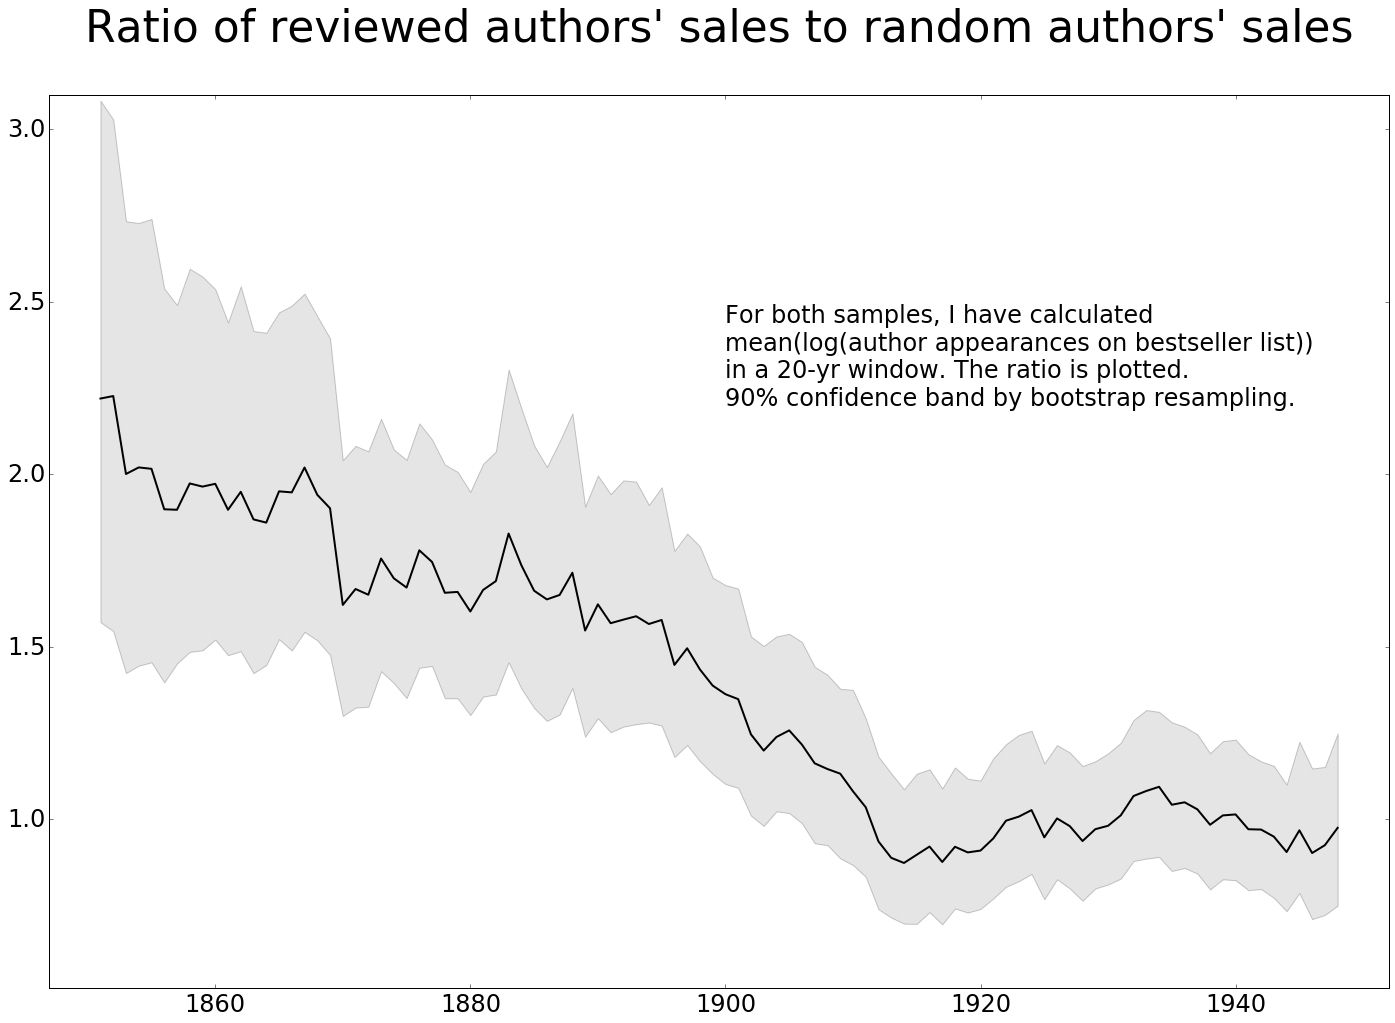

In [11]:
dfdict = dict()
dfdict['rev'] = []
dfdict['year'] = []
dfdict['notrev'] = []
dfdict['ratio'] = []
dfdict['ratiomax'] = []
dfdict['ratiomin'] = []

for i in range(1851, 1949):
    floor = i - 10
    ceiling = i + 10
    timeslice = authordata[(authordata.midcareer >= floor) & (authordata.midcareer < ceiling)]
    reviewed = timeslice.posterior[timeslice.binaryreview == 1].copy()
    notreviewed = timeslice.posterior[timeslice.binaryreview == 0].copy()
    averageforreviewed = np.mean(reviewed)
    averagefornot = np.mean(notreviewed)
    dfdict['year'].append(i)
    dfdict['rev'].append(averageforreviewed)
    dfdict['notrev'].append(averagefornot)
    dfdict['ratio'].append(averageforreviewed / averagefornot)
    sampleratios = []
    for i in range(1000):
        samplerev = np.random.choice(reviewed, replace = True, 
                         size = len(reviewed))
        samplenot = np.random.choice(notreviewed, replace = True,
                                    size = len(notreviewed))
        sampleratios.append(np.mean(samplerev) / np.mean(samplenot))
    sampleratios = sorted(sampleratios)
    dfdict['ratiomax'].append(sampleratios[950])
    dfdict['ratiomin'].append(sampleratios[49])
df = pd.DataFrame(dfdict)
# Two subplots, sharing the X axis
fig, ax = plt.subplots(figsize = (24,16))
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)
ax.set_title("Ratio of reviewed authors' sales to random authors' sales\n", fontsize = 44)
ax.plot(df.year, df.ratio, linewidth = 2, color = 'black')
ax.fill_between(df.year, df.ratiomin, df.ratiomax, facecolor='gray', alpha=0.2)
ax.text(1900, 2.2, 'For both samples, I have calculated\nmean(log(author appearances on bestseller list))\nin a 20-yr window. The ratio is plotted.\n90% confidence band by bootstrap resampling.', fontsize = 24)
ax.set_ylim(0.51, 3.1)
ax.set_xlim(1847,1952)
fig.savefig('../images/authorsalesratio.png', bbox_inches='tight')
plt.show()

In [50]:
import math
math.pow(np.mean(authordata.posterior), 2.71828)

0.14171490330664163

In [51]:
df.ratio

0     2.219449
1     2.226660
2     2.000533
3     2.019620
4     2.015532
5     1.898179
6     1.896777
7     1.973156
8     1.963958
9     1.972095
10    1.896686
11    1.948861
12    1.868821
13    1.859517
14    1.950201
15    1.947189
16    2.019362
17    1.940138
18    1.901118
19    1.620714
20    1.666925
21    1.650309
22    1.755294
23    1.697911
24    1.671055
25    1.779114
26    1.745287
27    1.655929
28    1.658423
29    1.601688
        ...   
68    0.902776
69    0.908107
70    0.943193
71    0.994814
72    1.006509
73    1.025467
74    0.946440
75    1.001332
76    0.978976
77    0.935770
78    0.970135
79    0.980028
80    1.010389
81    1.066444
82    1.081000
83    1.093080
84    1.041025
85    1.048165
86    1.027801
87    0.982955
88    1.010044
89    1.012994
90    0.970003
91    0.969035
92    0.948464
93    0.903887
94    0.966795
95    0.900999
96    0.923720
97    0.974048
Name: ratio, dtype: float64

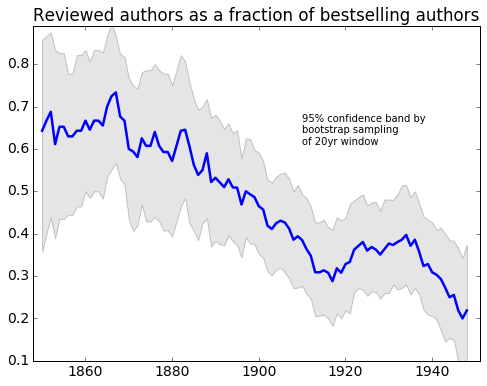

In [6]:
fig, ax = plt.subplots(figsize = (8,6))
matplotlib.rcParams.update({'font.size': 14})
ax.plot(x, revinallbest, linewidth = 2.5)
ax.set_title('Reviewed authors as a fraction of bestselling authors')
ax.set_ylim(0.1, 0.89)
ax.set_xlim(1848, 1951)
ax.fill_between(x, raibmin, raibmax, facecolor='gray', alpha=0.2)
ax.text(1910, 0.61, '95% confidence band by\nbootstrap sampling\nof 20yr window', fontsize = 10)
fig.savefig('images/authorfractions2.png', bbox_inches='tight')
plt.show()

In [7]:
onlyboth['binaryreview'] = crudedata.binaryreview
y, X = dmatrices('binaryreview ~ midcareer * posterior + is_us', data=onlyboth, return_type='dataframe')

newlm = smf.Logit(y, X).fit()
newlm.summary()

Optimization terminated successfully.
         Current function value: 0.645934
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           binaryreview   No. Observations:                  927
Model:                          Logit   Df Residuals:                      922
Method:                           MLE   Df Model:                            4
Date:                Sun, 28 May 2017   Pseudo R-squ.:                 0.06005
Time:                        11:22:58   Log-Likelihood:                -598.78
converged:                       True   LL-Null:                       -637.03
                                        LLR p-value:                 9.561e-16
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -29.7720      7.157     -4.160      0.000     -43.800     -15.744
midcareer               0.0154      0.004      4.075      0.000       0.008       0.023
posterior              44.4050     14.079      3.154      0.002      16.811      71.999
midcareer:posterior    -0.0227      0.007     -3.077      0.002      -0.037      -0.008
is_us                  -0.3140      0.141     -2.227      0.026      -0.590      -0.038
=======================================================================================
"""

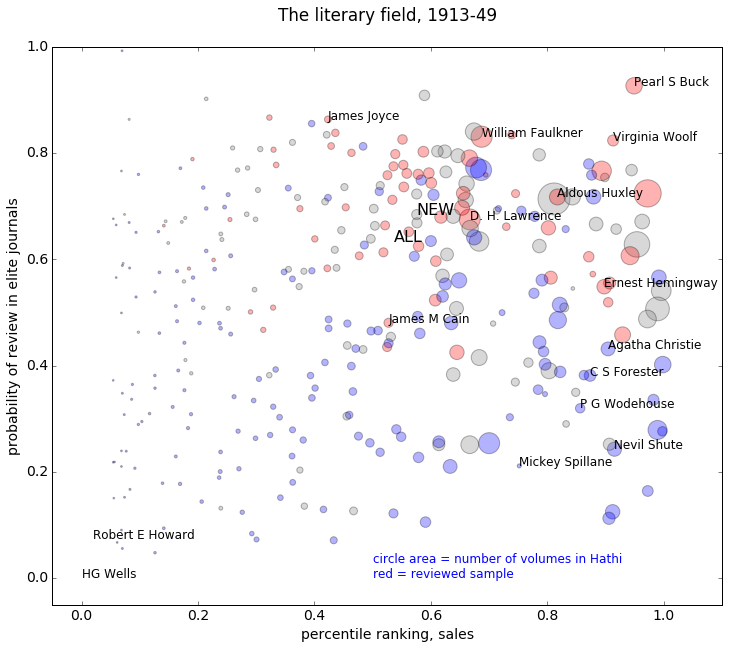

In [8]:
superelite = pd.read_csv('../fiction/superelite.csv')
superelite.drop_duplicates(subset = 'author', inplace = True)
superelite.set_index('author', inplace = True)

def get_a_period(aframe, floor, ceiling):
    ''' Extracts a chronological slice of our data.
    '''
    subset = aframe[(aframe.midcareer >= floor) & (aframe.midcareer < ceiling)]
    x = subset.percentile
    y = subset.prestige
    return x, y, subset

def get_an_author(anauthor, aframe):
    ''' Gets coordinates for an author in a given space.
    '''
    if anauthor not in aframe.index:
        return 0, 0
    else:
        x = aframe.loc[anauthor, 'percentile']
        y = aframe.loc[anauthor, 'prestige']
        return x, y

def plot_author(officialname, vizname, aperiod, ax):
    x, y = get_an_author(officialname, aperiod)
    ax.text(x, y, vizname, fontsize = 12)

def revtocolor(number):
    if number > 0.1:
        return 'red'
    else:
        return 'blue'

def elitemap(anid):
    global superelite, modernity2
    if modernity2.loc[anid, 'reviews'] < 0.5:
        return 'blue'
    elif anid not in superelite.index:
        return 'gray'
    elif superelite.loc[anid, 'tags'] == 'elite':
        return 'red'
    else:
        return 'gray'
        
# Let's plot modernism!

xvals, yvals, modernity2 = get_a_period(onlyboth, 1913,1950) 
modernauthors = pd.Series(modernity2.index.values)
samplecolor = pd.Series(data = modernauthors.apply(elitemap).values, index = modernity2.index.values)
modernity2 = modernity2.assign(samplecolor = samplecolor)
for marker in ['o', '^']:
    
ax = modernity2.plot.scatter(x = 'percentile', y = 'prestige', s = modernity2.num_vols * 3, 
                             c = modernity2.samplecolor, alpha = 0.3, figsize = (12,10))

authors_to_plot = {'Cain, James M': 'James M Cain', 'Faulkner, William': 'William Faulkner',
                   'Wells, H. G': 'HG Wells', 'Hemingway, Ernest': 'Ernest Hemingway',
                  'Joyce, James': 'James Joyce', 'Forester, C. S. (Cecil Scott)': 'C S Forester',
                  'Spillane, Mickey': 'Mickey Spillane', 'Huxley, Aldous': 'Aldous Huxley',
                   'Howard, Robert E': 'Robert E Howard', 'Buck, Pearl S': 'Pearl S Buck',
                  'Shute, Nevil': 'Nevil Shute', 'Lawrence, D. H': 'D. H. Lawrence',
                   'Christie, Agatha': 'Agatha Christie',
                   'Wodehouse, P. G': 'P G Wodehouse', 'Woolf, Virginia': 'Virginia Woolf'}

for officialname, vizname in authors_to_plot.items():
    plot_author(officialname, vizname, modernity2, ax)

ax.set_xlabel('percentile ranking, sales')
ax.set_ylabel('probability of review in elite journals')
ax.set_title('The literary field, 1913-49\n')
ax.text(0.5, 0.0, 'circle area = number of volumes in Hathi\nred = reviewed sample', color = 'blue', fontsize = 12)

oldcenterx = np.mean(modernity2.percentile[modernity2.reviews > 0.5])
oldcentery = np.mean(modernity2.prestige[modernity2.reviews > 0.5])
ax.text(oldcenterx, oldcentery, 'ALL', fontsize = 16)
subset = modernity2.loc[superelite.index, :]
newcenterx = np.mean(subset.percentile[subset.reviews > 0.5])
newcentery = np.mean(subset.prestige[subset.reviews > 0.5])
ax.text(newcenterx, newcentery, 'NEW', fontsize = 16)

ax.set_ylim((-0.05,1))
ax.set_xlim((-0.05, 1.1))
plt.show()

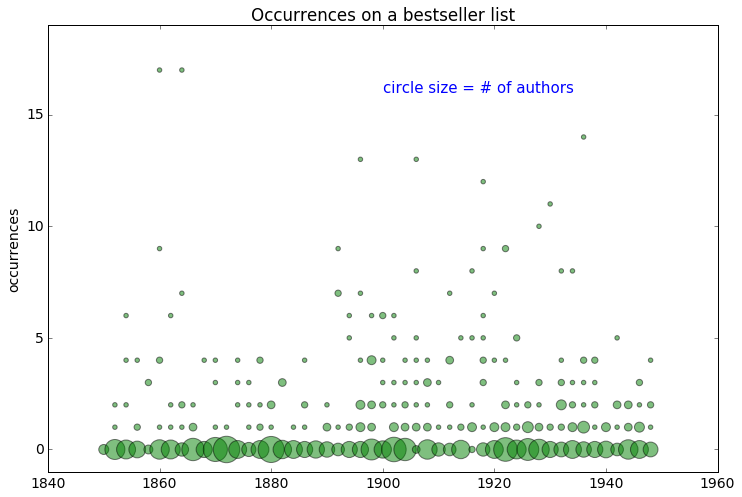

In [9]:
def get_binned_grid(authordata, yvariable):
    ''' This creates a dataframe that can be used to produce
    a scatterplot where circle size
    is proportional to the number of authors located in a
    particular "cell" of the grid.
    '''
    lv = []
    ls = []
    binsize = []
    for i in np.arange(1850, 1950, 2):
        for j in np.arange(0, 20):
            thisbin = authordata[(authordata.midcareer >= i - 1) & (authordata.midcareer < i + 1) & (authordata[yvariable] >= j - 0.45) & (authordata[yvariable] < j + 0.45)]
            if len(thisbin) > 0:
                lv.append(i)
                ls.append(j)
                binsize.append(len(thisbin))

    dfdict = {'date': lv, 'log-scaled sales evidence': ls, 'binsize': binsize}
    df = pd.DataFrame(dfdict)
    return df

df = get_binned_grid(authordata, 'salesevidence')

ax = df.plot.scatter(x = 'date', y = 'log-scaled sales evidence', s = df.binsize * 20, color = 'green', 
                alpha = 0.5, figsize = (12,8), title = 'Occurrences on a bestseller list')
ax.set_xlabel('')
ax.set_ylabel('occurrences')
ax.text(1900,16, 'circle size = # of authors', fontsize = 15, color = 'blue')
ax.set_ylim((-1, 19))
plt.savefig('rawoccurrences.png', bbox_inches = 'tight')
plt.show()

In [10]:
predictions = pd.read_csv('../fiction/prestigery.csv')
equivalence = {0: 'gray', 1: 'red'}
predictions = predictions.assign(colours = predictions.realclass.map(equivalence))

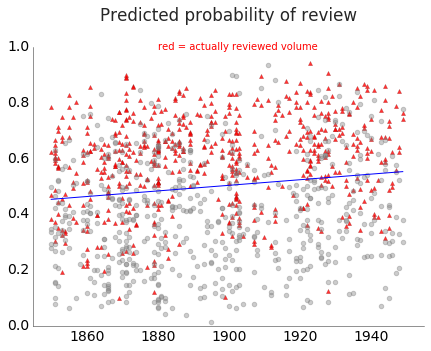

In [11]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize = (7,5))

# Save a nice dark grey as a variable
almost_black = '#262626'

# Remove top and right axes lines ("spines")
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

# Get rid of ticks. The position of the numbers is informative enough of
# the position of the value.
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# For remaining spines, thin out their line and change the black to a slightly off-black dark grey
almost_black = '#262626'
spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)
    ax.spines[spine].set_color(almost_black)

# Change the labels to the off-black
ax.xaxis.label.set_color(almost_black)
ax.yaxis.label.set_color(almost_black)

# Change the axis title to off-black
ax.title.set_color(almost_black)

ax.scatter(predictions.dateused[predictions.realclass == 1],
           predictions.logistic[predictions.realclass == 1], 
           marker = "^", color = 'red', alpha = 0.8, edgecolor = almost_black, linewidth = 0.15)
ax.scatter(predictions.dateused[predictions.realclass == 0],
           predictions.logistic[predictions.realclass == 0], marker = "o", color = 'gray', alpha = 0.4)
ax.set_ylim((0,1))
ax.set_xlim((1845,1955))
ax.set_title('Predicted probability of review\n')
ax.text(1880,0.99,'red = actually reviewed volume', color = 'red', fontsize = 10)
lm = smf.ols(formula='logistic ~ dateused', data=predictions).fit()
xpred = np.linspace(1850, 1949, 100)
xpred = pd.DataFrame({'dateused': xpred})
ypred = lm.predict(xpred)
plt.plot(xpred, ypred, linewidth = 1)
fig.savefig('data/logisticpredictions.png', bbox_inches = 'tight')
plt.show()

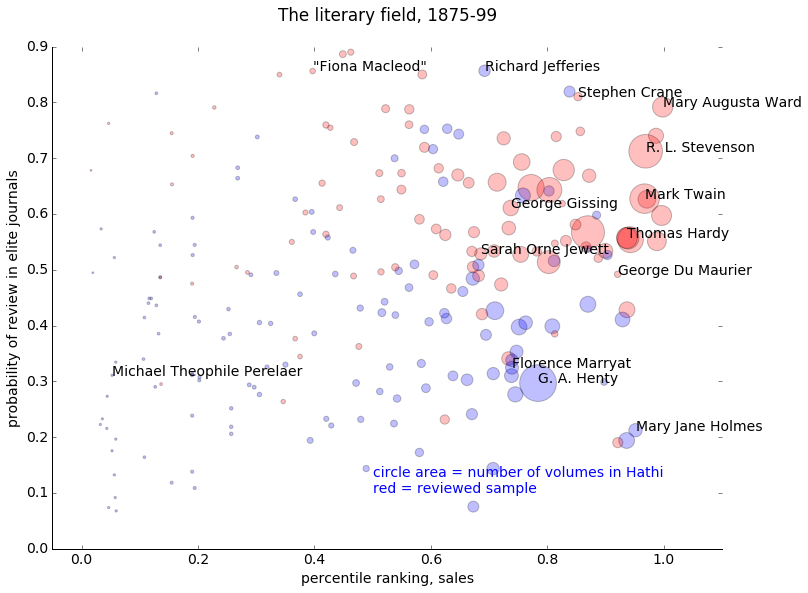

In [41]:
def get_a_period(aframe, floor, ceiling):
    ''' Extracts a chronological slice of our data.
    '''
    subset = aframe[(aframe.midcareer >= floor) & (aframe.midcareer < ceiling)]
    x = subset.percentile
    y = subset.prestige
    return x, y, subset

def get_an_author(anauthor, aframe):
    ''' Gets coordinates for an author in a given space.
    '''
    if anauthor not in aframe.index:
        return 0, 0
    else:
        x = aframe.loc[anauthor, 'percentile']
        y = aframe.loc[anauthor, 'prestige']
        return x, y

def plot_author(officialname, vizname, aperiod, ax):
    x, y = get_an_author(officialname, aperiod)
    ax.text(x, y, vizname, fontsize = 14)

def revtocolor(number):
    if number > 0.1:
        return 'red'
    else:
        return 'blue'

def revtobinary(number):
    if number > 0.1:
        return 1
    else:
        return 0
    
# Let's plot the mid-Victorians

xvals, yvals, victoriana2 = get_a_period(onlyboth, 1875, 1899)
victoriana2 = victoriana2.assign(samplecolor = victoriana2.reviews.apply(revtocolor))
ax = victoriana2.plot.scatter(x = 'percentile', y = 'prestige', s = victoriana2.num_vols * 3 + 3, alpha = 0.25,
                             c = victoriana2.samplecolor, figsize = (12,9))

authors_to_plot = {'Hardy, Thomas': 'Thomas Hardy', 'Stevenson, Robert Louis': 'R. L. Stevenson',
                  'Crane, Stephen': 'Stephen Crane', 'Twain, Mark': 'Mark Twain',
                  'Henty, G. A': 'G. A. Henty', 'Marryat, Florence': 'Florence Marryat',
                  'Jewett, Sarah Orne': 'Sarah Orne Jewett', 'Macleod, Fiona': '"Fiona Macleod"',
                  'Jefferies, Richard': 'Richard Jefferies', 'Ward, Mary Augusta': 'Mary Augusta Ward',
                  'Holmes, Mary Jane': 'Mary Jane Holmes', 'Du Maurier, George': 'George Du Maurier',
                  'Perelaer, Michael Theophile Hubert': 'Michael Theophile Perelaer',
                  'Gissing, George': 'George Gissing'}

for officialname, vizname in authors_to_plot.items():
    plot_author(officialname, vizname, victoriana2, ax)

ax.set_xlabel('percentile ranking, sales')
ax.set_ylabel('probability of review in elite journals')
ax.set_title('The literary field, 1875-99\n')
ax.text(0.5, 0.1, 'circle area = number of volumes in Hathi\nred = reviewed sample', color = 'blue', fontsize = 14)
ax.set_ylim((0,0.9))
ax.set_xlim((-0.05,1.1))

#victoriana = victoriana.assign(binaryreview = victoriana.reviews.apply(revtobinary))
#y, X = dmatrices('binaryreview ~ percentile + prestige', data=victoriana, return_type='dataframe')
#crudelm = smf.Logit(y, X).fit()
#params = crudelm.params
#theintercept = params[0] / -params[2]
#theslope = params[1] / -params[2]
#newX = np.linspace(0, 1, 20)
#abline_values = [theslope * i + theintercept for i in newX]
#ax.plot(newX, abline_values, color = 'black')
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)
plt.savefig('images/field1875noline.png', bbox_inches = 'tight')
plt.show()

In [45]:
mainmeta = pd.read_csv('../fiction/prestigeficmeta.csv')
print(mainmeta.shape)
mainmeta = mainmeta.dropna(subset = ['pubname'])
print(mainmeta.shape)

(1245, 25)
(606, 25)


In [54]:
def forcefloat(astring):
    try:
        fval = float(astring)
    except:
        fval = 0
    return fval

mainmeta['yrrev'] = mainmeta['yrrev'].apply(forcefloat)
grouped = mainmeta.loc[ :, ['earliestdate', 'yrrev', 'pubname']].groupby('pubname')
venues = grouped.aggregate(['min', 'max', 'count'])
venues


earliestdate               yrrev              
                  min   max count     min     max count
pubname                                                
                 1854  1854     1     0.0     0.0     1
ADL              1920  1949    11  1923.0  1949.0     9
ATL              1859  1948   197  1860.0  1949.0   197
BM               1861  1896    71  1861.0  1896.0    71
CRIS             1921  1938     6  1922.0  1938.0     6
CRIT             1924  1938    12  1924.0  1939.0    12
DIAL             1913  1926     5  1921.0  1927.0     5
DUB              1929  1947    10  1930.0  1949.0    10
EGO              1913  1918     9  1914.0  1918.0     9
ER               1850  1859    18  1850.0  1859.0    18
FR               1865  1911   102  1865.0  1912.0   102
HOR              1939  1945     5  1940.0  1946.0     5
LM               1919  1936    11  1920.0  1936.0    11
MM               1879  1883     4  1880.0  1884.0     4
NR               1915  1947    33  1915.0  1947.0    29
NY               1925  1945    17  1925.0  1947.0    16
Pulitzer         1924  1936     3     NaN     NaN     0
QR               1851  1851     3  1857.0  1857.0     3
SCRU             1940  1946     3  1940.0  1946.0     3
TEM              1851  1859    33  1852.0  1859.0    33
TLR              1914  1915     3  1914.0  1915.0     3
TLS              1920  1928     7  1920.0  1923.0     5
TNA              1903  1913    19  1907.0  1920.0    19
YAL              1930  1949    16  1930.0  1949.0    16
YB               1885  1895     7  1895.0  1895.0     7

In [51]:
venues.columns.values

array([('earliestdate', 'min'), ('earliestdate', 'max'),
       ('earliestdate', 'count'), ('yrrev', 'min'), ('yrrev', 'max'),
       ('yrrev', 'count')], dtype=object)

In [53]:
np.sum(venues[('earliestdate', 'count')])

606